# Image Caption Generation

### Importing required packages

In [166]:
import pandas as pd
import spacy
from collections import Counter, OrderedDict
import os
from pathlib import Path
import torch
import torch.nn as nn 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [3]:
VOCAB_SIZE = 20000
THRESHOLD_FREQ = 5
BATCH_SIZE = 16

### Importing caption data

In [4]:
df = pd.read_csv('data/flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Root path for images

In [5]:
root_path = 'data/flickr8k/images'

### Tokenizer

In [6]:
nlp = spacy.load("en_core_web_sm")

def tokenizer(text):
    return [token.text.lower() for token in nlp.tokenizer(text)]

### Vocabulary class

In [7]:
class Vocabulary:    
    def __init__(self):
        self.vocabulary = None 
        
    def build_vocabulary(self, sentences):
        token_counter = Counter()
        for sentence in sentences:
            token_counter.update(tokenizer(sentence))
        sorted_by_freq_tuples = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)[:VOCAB_SIZE]
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
        specials = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        self.vocabulary = vocab(ordered_dict, specials=specials, min_freq=THRESHOLD_FREQ)
        self.vocabulary.set_default_index(self.vocabulary['<UNK>'])
    
    def numericalize(self, sentence):
        tokenized_sentence = tokenizer(sentence)
        return [self.vocabulary[token] if token in self.vocabulary else self.vocabulary['<UNK>'] for token in tokenized_sentence] 
    
    def denumericalize(self, list):
        return [self.vocabulary.get_itos()[idx] if idx < len(self.vocabulary) else '<UNK>' for idx in list ]

In [135]:
v1 = Vocabulary()
v1.build_vocabulary(df['caption'].to_list())

### Custom Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_path, captions_df, transform=None):
        super().__init__()
        self.root_path = root_path
        self.df = captions_df 
        self.transform = transform
        
        self.image_names = self.df['image']
        self.captions = self.df['caption']
        
        self.v1 = Vocabulary()
        self.v1.build_vocabulary(self.captions.to_list())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        rgb_image = Image.open(Path(os.path.join(self.root_path, image_name))).convert('RGB')
        
        if self.transform is not None:
            rgb_image = self.transform(rgb_image)
            
        caption = self.captions[index]
        
        numericalized_caption = [self.v1.vocabulary['<SOS>']]
        numericalized_caption.extend(self.v1.numericalize(caption))
        numericalized_caption.append(self.v1.vocabulary['<EOS>'])
        
        return rgb_image, torch.tensor(numericalized_caption)

### Image Transform and dataset

In [9]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(256, scale=(0.95, 1.0)),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.CenterCrop(size=224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ]
)
dataset = CustomDataset(root_path, df, transform)

In [10]:
print(f'Shape of Image tensor : {dataset[0][0].shape}')

Shape of Image tensor : torch.Size([3, 224, 224])


In [11]:
print(f'Shape of Caption tensor : {dataset[0][1].shape}')

Shape of Caption tensor : torch.Size([20])


### Creating collate function for DataLoader

In [12]:

batch_size = 16
x = [dataset[i][0].unsqueeze(0) for i in range(batch_size)]
y = [dataset[i][1].unsqueeze(0) for i in range(batch_size)]
batch = [[dataset[i][0], dataset[i][1] ]for i in range(batch_size)]

In [13]:
for i in range(16):
    print(i, f'| Image tensor shape: {batch[i][0].shape}', f' | Caption tensor shape: {batch[i][1].shape}')

0 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([20])
1 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([10])
2 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([11])
3 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([12])
4 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([15])
5 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([11])
6 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([19])
7 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([21])
8 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([15])
9 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torch.Size([11])
10 | Image tensor shape: torch.Size([3, 224, 224])  | Caption tensor shape: torc

In [14]:
print(f'Image batch shape (from dataloader) = {torch.cat([item[0].unsqueeze(0) for item in batch], dim=0).shape}')

Image batch shape (from dataloader) = torch.Size([16, 3, 224, 224])


In [15]:
targets = [item[1] for item in batch]
targets = pad_sequence(targets, batch_first=True, padding_value=0)
print(f'Caption batch shape (from dataloader) = {targets.shape}')

Caption batch shape (from dataloader) = torch.Size([16, 23])


In [16]:
class Collate:
    def __init__(self, pad_idx) :
        self.pad_idx = pad_idx 
    
    def __call__(self, batch):
        images = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return images, targets 

In [17]:
collate_fn = Collate(0)
out = collate_fn(batch)
print(f'Image batch shape (from dataloader) = {out[0].shape}')
print(f'Caption batch shape (from dataloader) = {out[0].shape}')

Image batch shape (from dataloader) = torch.Size([16, 3, 224, 224])
Caption batch shape (from dataloader) = torch.Size([16, 3, 224, 224])


### DataLoader

In [18]:
def get_dataloader(root_path, captions_df, transform, batch_size, shuffle=True):
    dataset = CustomDataset(root_path, captions_df, transform)
    pad_idx = dataset.v1.vocabulary['<PAD>']
    dataloader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = Collate(pad_idx=pad_idx)
    )
    return dataloader

In [19]:
datalaoder = get_dataloader(root_path, df, transform, BATCH_SIZE)

In [77]:
batch = next(iter(datalaoder))
print(f'Image batch shape = {batch[0].shape}')
print(f'Text batch shape = {batch[1].shape}')

Image batch shape = torch.Size([16, 3, 224, 224])
Text batch shape = torch.Size([16, 23])


### Encoder

In [32]:
class Encoder(nn.Module):
    def __init__(self, embed_size, train_image_model = False) :
        super(Encoder, self).__init__()
        self.train_image_model = train_image_model 
        self.efficient_net_model = models.efficientnet_v2_m(weights='DEFAULT')
        self.efficient_net_model.classifier[1] = nn.Linear(self.efficient_net_model.classifier[1].in_features, embed_size)
        for name, params in self.efficient_net_model.named_parameters():
            if name == 'classifier.1.weight' or name == 'classifier.1.bias':
                params.requires_grad = True 
            else:
                params.requires_grad = self.train_image_model
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, images):
        # images_size = [batch_size, 3, 224, 224]
        x = self.efficient_net_model(images)
        x = self.relu(x)
        x = self.dropout(x)
        # x_size = [batch_size, embed_size]
        return x         

In [70]:
vocab_size = len(datalaoder.dataset.v1.vocabulary)
embed_size = 256
hidden_size = 64
num_layers = 2

In [71]:
enc = Encoder(embed_size)
encoded = enc(batch[0])

In [79]:
print(f'Image batch shape = {batch[0].shape}')
print(f'Image batch shape after encoding = {encoded.shape}')

Image batch shape = torch.Size([16, 3, 224, 224])
Image batch shape after encoding = torch.Size([16, 256])


### Decoder

In [76]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        # features_size = [batch_size, embed_size]
        embeddings = self.embed(captions)
        # embeddings_size = [batch_size, batch_length, embed_size]
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        # embeddings_size = [batch_size, batch_length+1, embed_size]
        out, _ = self.lstm(embeddings)
        out = self.linear(out)
        # out_size = [batch_size, batch_length+1, vocab_size]
        return out

In [74]:
dec = Decoder(embed_size, hidden_size, vocab_size, num_layers)
decoded = dec(encoded, batch[1])

In [80]:
print(f'Image batch shape = {batch[0].shape}')
print(f'Text batch shape = {batch[1].shape}')
print(f'Batch shape after decoding = {decoded.shape}')

Image batch shape = torch.Size([16, 3, 224, 224])
Text batch shape = torch.Size([16, 23])
Batch shape after decoding = torch.Size([16, 18, 2994])


### Encoder Decoder

In [133]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs 
    
    def caption_generator(self, image, vocabulary_v1, max_length=50):
        result = []
        
        with torch.no_grad():
            x = self.encoder(image.unsqueeze(0))
            states = None 
            
            for _ in range(max_length):
                out, states = self.decoder.lstm(x, states)
                out = self.decoder.linear(out)
                predicted = torch.argmax(out, 1)
                result.append(predicted.item())
                x = self.decoder.embed(predicted)
                
                if predicted.item() == vocabulary_v1.vocabulary['<EOS>']:
                    break
            
        return ' '.join(vocabulary_v1.denumericalize(result))

Image shape = torch.Size([3, 224, 224])


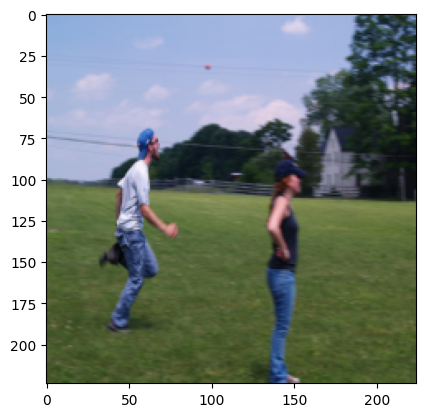

Generated Caption = cookie cookie cop dumps dumps dumps sparklers sunny sunny sunny gathers preparing preparing preparing cop cop dumps dumps dumps pony pony beyond beyond stove disc lipstick fuzzy cookie derby pine sparklers preparing preparing preparing preparing cop but dumps dumps dumps sparklers sunny sunny sunny gathers preparing preparing preparing cop cop


In [157]:
enc_dec = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
print(f'Image shape = {batch[0][0].shape}')
plt.imshow(batch[0][0].permute(1, 2, 0))
plt.show()
generated_caption = enc_dec.caption_generator(batch[0][0])
print(f'Generated Caption = {generated_caption}')

In [204]:
enc_dec(batch[0], batch[1])[:, :-1, :].shape

torch.Size([16, 23, 2994])

In [205]:
outputs = enc_dec(batch[0], batch[1])[:, :-1, :]

In [206]:
loss_function = nn.CrossEntropyLoss()
loss_function(outputs.reshape(-1, outputs.shape[2]), batch[1].reshape(-1))

tensor(7.9835, grad_fn=<NllLossBackward0>)

In [167]:
vocab_size = len(v1.vocabulary)
embed_size = 256
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 100
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
model.to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=v1.vocabulary['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [207]:
def training(model, optimizer, loss_fn, data_loader, num_epochs=100):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_idx, batch in enumerate(data_loader):
            images = batch[0].to(device)
            captions = batch[1].to(device)
            output = model(images, captions)
            output = output[:, :-1, :]
            loss = loss_fn(output.reshape(-1, output.shape[2]), captions.reshape(-1))
            optimizer.zero_grad()
            loss.bacward()
            optimizer.step()
            if batch_idx % 100 == 0 :
                print(f'Epoch No. {epoch+1}/{num_epochs} | Loss = {loss:.5f}')
                plt.imshow(batch[0][0].permute(1, 2, 0))
                plt.show()
                generated_caption = model.caption_generator(batch[0][0])
                print(f'Generated Caption = {generated_caption}')
    return model